In [4]:
import numpy as np
import glob

from annoy import AnnoyIndex

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [5]:
gameName = "loderunner"
rowLength = 32
numOfRows = 22

In [6]:
columnRefArray = np.array([np.arange(1, 32) for i in range(numOfRows+5)]).flatten()
print(columnRefArray)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17
 18 19 20 21 22 23 24 25 26 27 28 29 30 31  1  2  3  4  5  6  7  8  9 10
 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  1  2  3
  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26 27 28 29 30 31  1  2  3  4  5  6  7  8  9 10 11 12 13
 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  1  2  3  4  5  6
  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16
 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  1  2  3  4  5  6  7  8  9
 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31  1  2
  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19

In [7]:
lrStringLevelPaths = sorted(glob.glob("../data/vglc/Lode Runner/Processed/Level*.txt"))
lrStringLevelPaths

['../data/vglc/Lode Runner/Processed/Level 1.txt',
 '../data/vglc/Lode Runner/Processed/Level 10.txt',
 '../data/vglc/Lode Runner/Processed/Level 100.txt',
 '../data/vglc/Lode Runner/Processed/Level 101.txt',
 '../data/vglc/Lode Runner/Processed/Level 102.txt',
 '../data/vglc/Lode Runner/Processed/Level 103.txt',
 '../data/vglc/Lode Runner/Processed/Level 104.txt',
 '../data/vglc/Lode Runner/Processed/Level 105.txt',
 '../data/vglc/Lode Runner/Processed/Level 106.txt',
 '../data/vglc/Lode Runner/Processed/Level 107.txt',
 '../data/vglc/Lode Runner/Processed/Level 108.txt',
 '../data/vglc/Lode Runner/Processed/Level 109.txt',
 '../data/vglc/Lode Runner/Processed/Level 11.txt',
 '../data/vglc/Lode Runner/Processed/Level 110.txt',
 '../data/vglc/Lode Runner/Processed/Level 111.txt',
 '../data/vglc/Lode Runner/Processed/Level 112.txt',
 '../data/vglc/Lode Runner/Processed/Level 113.txt',
 '../data/vglc/Lode Runner/Processed/Level 114.txt',
 '../data/vglc/Lode Runner/Processed/Level 115.txt

In [39]:
import shutil
import os

# if os.path.isdir("lrLSTMData"):
#     shutil.rmtree("lrLSTMData/")

# os.mkdir("lrLSTMData/")

tiles = {
    "B" : 0,
    "b" : 1,
    "@" : 2,
    "." : 3,
    "-" : 4,
    "#" : 5,
    "G" : 6,
    "E" : 7,
    "M" : 8,
}

padSize = rowLength * 3 # lode runner row length * 3 as paper uses previous 3 rows for lstm
N = padSize

sosArray = np.ones(shape=(1)) * 9
eosArray = np.ones(shape=(1)) * 5

xTrain = []
yTrain = []
xTrainTargetIn = []
columnRef = []

batchNum = 0

for i, levelStringPath in enumerate(lrStringLevelPaths):

    with open(levelStringPath, "r") as f:
        levelString = np.array([list(line[:-1]) for line in f.readlines()]).flatten()
        levelString = np.array([tiles[tileChar] for tileChar in levelString])

    for j in range(len(levelString) - N):

        padLength = (N - j) if j < N else 0
        RowCutOff = 0 if j <= N else RowCutOff+1
        # print(f"RowCutOff: {RowCutOff}")
        # print(f"j: {j}, N: {N}")
        # print(j < N)
        # print(padLength)

        dataI = np.concatenate((np.zeros(shape=(padLength)), levelString[RowCutOff:j]), axis=0)
        # print(f"dataI shape: {dataI.shape}")

        dataT = levelString[j:j+N]
        targetIn = np.concatenate((sosArray, dataT))
        targetOut = np.concatenate((dataT, eosArray))

        #levelIdx = np.concatenate((np.zeros(shape=(padLength)), columnRefArray[RowCutOff:j]), axis=0)
        levelIdx = np.array(columnRefArray[j:N+j])
        dataC = np.zeros(shape=(N, 256))
        for t in range(N): dataC[t][int(levelIdx[t])] = 1
        # print(f"dataC shape: {dataC.shape} : {dataC[-1]}")

        columnRef.append(dataC)
        xTrain.append(dataI)
        xTrainTargetIn.append(targetIn)
        yTrain.append(targetOut)

    if len(xTrain) / 32 >= 100.0:

        savePath = f"lrVGCLLSTMData/batch{batchNum}"

        np.save(f"{savePath}xTrain.npy", np.array(xTrain))
        np.save(f"{savePath}xTrainTargetIn.npy", np.array(xTrainTargetIn))
        np.save(f"{savePath}yTrain.npy", np.array(yTrain))
        np.save(f"{savePath}columnRef.npy", np.array(columnRef))

        xTrain = []
        yTrain = []
        xTrainTargetIn = []
        columnRef = []

        batchNum += 1

if len(xTrain) > 0:

    savePath = f"lrLSTMData/batch{batchNum}"

    np.save(f"{savePath}xTrain.npy", np.array(xTrain))
    np.save(f"{savePath}xTrainTargetIn.npy", np.array(xTrainTargetIn))
    np.save(f"{savePath}yTrain.npy", np.array(yTrain))
    np.save(f"{savePath}columnRef.npy", np.array(columnRef))


# xTrain = np.array(xTrain)
# xTrainTargetIn = np.array(xTrainTargetIn)
# yTrain = np.array(yTrain)
# columnRef = np.array(columnRef)

In [61]:
class LSTMModel(nn.Module):

    def __init__(self, debug=False):
        super().__init__()

        self.histLSTM = nn.LSTM(1, 128, batch_first=True)
        self.colLSTM = nn.LSTM(256, 128, batch_first=True)

        self.textLSTM = nn.LSTM(1, 128, batch_first=True)

        self.outputLayer = nn.Linear(128, 9)

    def forward(self, xHist, xText, xCol):
        
        histOut, (histH, histC) = self.histLSTM(xHist)

        #print(f"hist out shape b4: {histOut.size()}")
        #histOut = histOut[-1, :, :]
        #print(f"hist out shape b4: {histOut.size()}")

        colOut, (colH, colC) = self.colLSTM(xCol)

        #colOut = colOut[:, -1]

        hiddenAdd = torch.add(histH, histC)
        channelAdd = torch.add(colH, colC)
        
        textOut, (textH, textC) = self.textLSTM(xText, (hiddenAdd, channelAdd))

        # print(f"text out size b4: {textOut.size()}")
        # if textOut.ndim == 2:
        #     textOut = textOut[-1, :]
        # else:
        #     textOut = textOut[:, -1, :]
        # print(f"text out size after: {textOut.size()}")

        output = nn.functional.softmax(self.outputLayer(textOut), dim=1)
        # print(f"Output Size SoftMax: {output.size()}")
        
        return output

In [44]:
def TrainModel(xTrain, xTrainTargetIn, yTrain, columnRef, epochs, batchSize):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = LSTMModel()
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, eps=1e-7)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-7)

    criterion = nn.MSELoss()

    model.to(device)
    model.train()

    losses = []

    print(f"xTrain b4 tensor shape: {xTrain.shape}")
    #xTrain = xTrain.reshape(xTrain.shape[0], xTrain.shape[2], xTrain.shape[1])
    #xTrainTargetIn = xTrainTargetIn.reshape(xTrainTargetIn.shape[0], xTrainTargetIn.shape[2], xTrainTargetIn.shape[1])
    #yTrain = yTrain.reshape(yTrain.shape[0], yTrain.shape[2], yTrain.shape[1])
    #columnRef = columnRef.reshape(columnRef.shape[0], columnRef.shape[2], columnRef.shape[1])

    for i in range(epochs):

        losses.append([])

        for j in range(0, xTrain.shape[0], batchSize):
            
            xTrainTensor = torch.tensor(xTrain[j:j+batchSize], dtype=torch.float32).to(device)
            xTrainTargetInTensor = torch.tensor(xTrainTargetIn[j:j+batchSize], dtype=torch.float32).to(device)

            yTrainTensor = torch.tensor(yTrain[j:j+batchSize], dtype=torch.float32).to(device)

            columnRefTensor = torch.tensor(columnRef[j:j+batchSize], dtype=torch.float32).to(device)

            print(xTrainTensor.shape)
            print(xTrainTargetInTensor.shape)
            print(yTrainTensor.shape)
            print(columnRefTensor.shape)

            #print(f"xTrain size: {xTrainTensor.size()}")

            yPred = model(xTrainTensor, xTrainTargetInTensor, columnRefTensor)
            
            #print(f"yPred size: {yPred.size()}")
            #print(f"yTruth size: {yTrainTensor.size()}")
            loss = criterion(yPred, yTrainTensor)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses[i].append(loss.cpu().detach().item())

        print(f"Epoch {i}: loss {sum(losses[i])/len(losses[i])}")
    
    return model

In [ ]:
model = TrainModel(xTrain, xTrainTargetIn, yTrain, columnRef, 25, 32)

In [84]:
import Utils.fastnumpyio as fnp

def TrainModelFromFiles(batchPaths, epochs, batchSize):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = LSTMModel()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.1, eps=1e-7)
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.01, eps=1e-7)

    criterion = nn.MSELoss()

    model.to(device)
    model.train()

    losses = []

    for i in range(epochs):

        losses.append([])

        for t in range(0, len(batchPaths)//2, 4):
            print(t)
            print(batchPaths[t:t+4])

            xTrain = fnp.load(batchPaths[t+1])
            xTrainTargetIn = fnp.load(batchPaths[t+2])
            yTrain = fnp.load(batchPaths[t+3])
            columnRef = fnp.load(batchPaths[t])

            for j in range(0, xTrain.shape[0], batchSize):

                xTrain = xTrain.reshape(xTrain.shape[0], xTrain.shape[1], 1)
                xTrainTargetIn = xTrainTargetIn.reshape(xTrainTargetIn.shape[0], xTrainTargetIn.shape[1], 1)
                yTrain = yTrain.reshape(yTrain.shape[0], yTrain.shape[1], 1)
                
                xTrainTensor = torch.tensor(xTrain[j:j+batchSize], dtype=torch.float32).to(device)
                xTrainTargetInTensor = torch.tensor(xTrainTargetIn[j:j+batchSize], dtype=torch.float32).to(device)

                yTrainTensor = torch.tensor(yTrain[j:j+batchSize], dtype=torch.float32).to(device)

                columnRefTensor = torch.tensor(columnRef[j:j+batchSize], dtype=torch.float32).to(device)

                # print(xTrainTensor.shape)
                # print(xTrainTargetInTensor.shape)
                # print(yTrainTensor.shape)
                # print(columnRefTensor.shape)

                #print(f"xTrain size: {xTrainTensor.size()}")

                yPred = model(xTrainTensor, xTrainTargetInTensor, columnRefTensor)
                
                #print(f"yPred size: {yPred.size()}")
                #print(f"yTruth size: {yTrainTensor.size()}")
                loss = criterion(yPred, yTrainTensor)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                losses[i].append(loss.cpu().detach().item())

            print(f"Epoch {i} Batch {t}: loss {losses[i][-1]}")

        print(f"Epoch {i}: loss {sum(losses[i])/len(losses[i])}")
    
    return model

In [85]:
model = TrainModelFromFiles(sorted(glob.glob(f"lrVGCLLSTMData/*")), 20, 32)

0
['lrVGCLLSTMData/batch0columnRef.npy', 'lrVGCLLSTMData/batch0xTrain.npy', 'lrVGCLLSTMData/batch0xTrainTargetIn.npy', 'lrVGCLLSTMData/batch0yTrain.npy']
Epoch 0 Batch 0: loss 1.9039191007614136
4
['lrVGCLLSTMData/batch10columnRef.npy', 'lrVGCLLSTMData/batch10xTrain.npy', 'lrVGCLLSTMData/batch10xTrainTargetIn.npy', 'lrVGCLLSTMData/batch10yTrain.npy']
Epoch 0 Batch 4: loss 10.220907211303711
8
['lrVGCLLSTMData/batch11columnRef.npy', 'lrVGCLLSTMData/batch11xTrain.npy', 'lrVGCLLSTMData/batch11xTrainTargetIn.npy', 'lrVGCLLSTMData/batch11yTrain.npy']
Epoch 0 Batch 8: loss 8.978261947631836
12
['lrVGCLLSTMData/batch12columnRef.npy', 'lrVGCLLSTMData/batch12xTrain.npy', 'lrVGCLLSTMData/batch12xTrainTargetIn.npy', 'lrVGCLLSTMData/batch12yTrain.npy']
Epoch 0 Batch 12: loss 8.088552474975586
16
['lrVGCLLSTMData/batch13columnRef.npy', 'lrVGCLLSTMData/batch13xTrain.npy', 'lrVGCLLSTMData/batch13xTrainTargetIn.npy', 'lrVGCLLSTMData/batch13yTrain.npy']
Epoch 0 Batch 16: loss 10.442082405090332
20
['lr

KeyboardInterrupt: 

In [63]:
torch.save(model, "lstmModel1VGLC.pt")

In [64]:
total = 0
for name, param in model.named_parameters():
    print(f"{name:<24}: {param.numel():5}")
    total += param.numel()

print(f"Total Params: {total}")

histLSTM.weight_ih_l0   :   512
histLSTM.weight_hh_l0   : 65536
histLSTM.bias_ih_l0     :   512
histLSTM.bias_hh_l0     :   512
colLSTM.weight_ih_l0    : 131072
colLSTM.weight_hh_l0    : 65536
colLSTM.bias_ih_l0      :   512
colLSTM.bias_hh_l0      :   512
textLSTM.weight_ih_l0   :   512
textLSTM.weight_hh_l0   : 65536
textLSTM.bias_ih_l0     :   512
textLSTM.bias_hh_l0     :   512
outputLayer.weight      :  1152
outputLayer.bias        :     9
Total Params: 332937


Random Start Point: 87
Input shape: (608, 96)
target shape: (608, 96)
column shape: (608, 96, 256)
Input shape: (608, 96, 1)
target shape: (608, 96, 1)
column shape: (608, 96, 256)
input size: torch.Size([96, 1])
target size: torch.Size([96, 1])
column size: torch.Size([96, 256])
Running Model
next col size: (96, 9)
next col size: (96,)
7
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
Part Level Image Shape: (3, 32)
input size: torch.Size([96, 1])
target size: torch.Size([96, 1])
column size: torch.Size([96, 256])
Running Model
next col size: (96, 9)
next col size: (96,)
7
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
Part Level Image Shape: (3, 32)
input size: torch.Size([96, 1])
target size: torch.Size

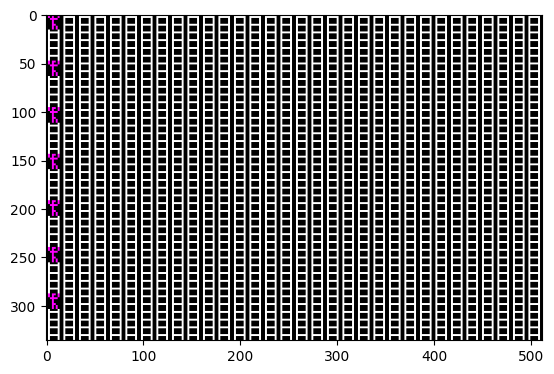

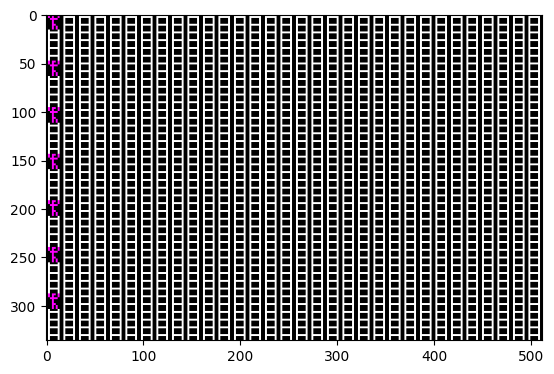

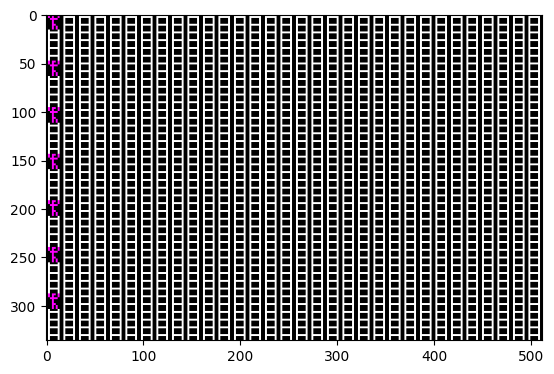

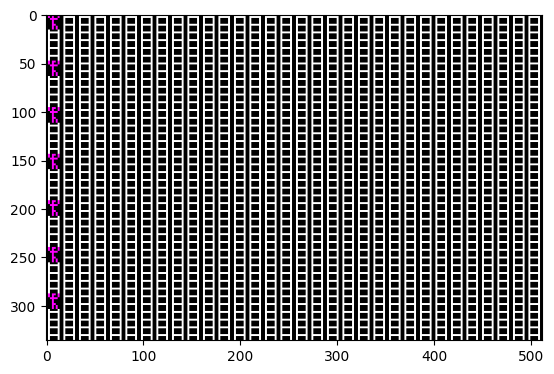

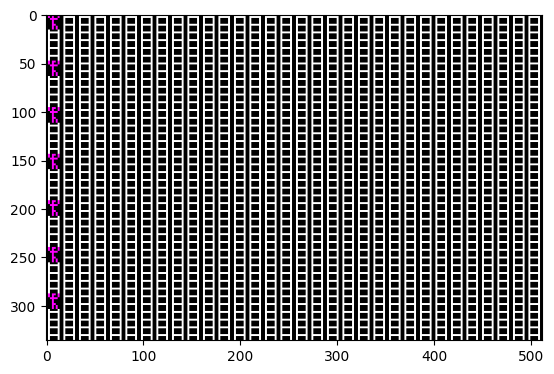

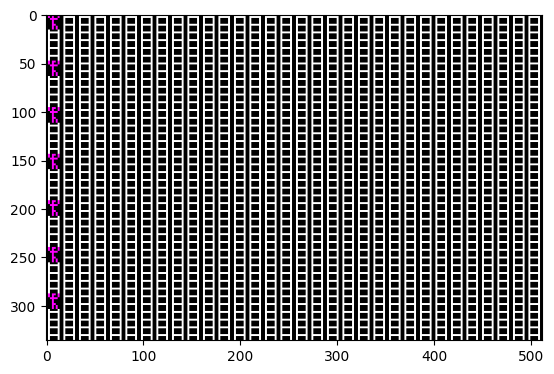

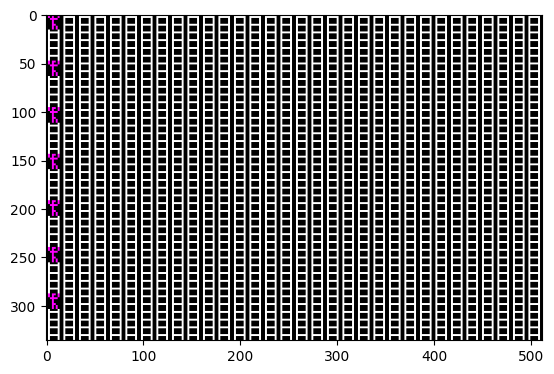

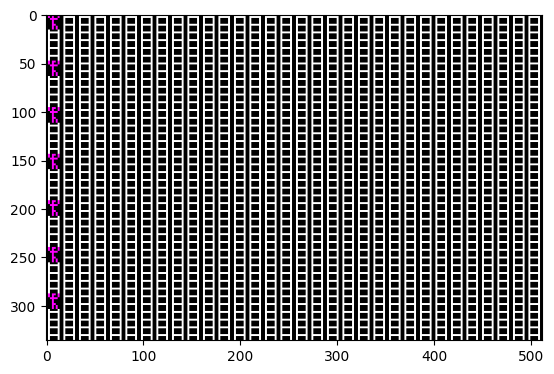

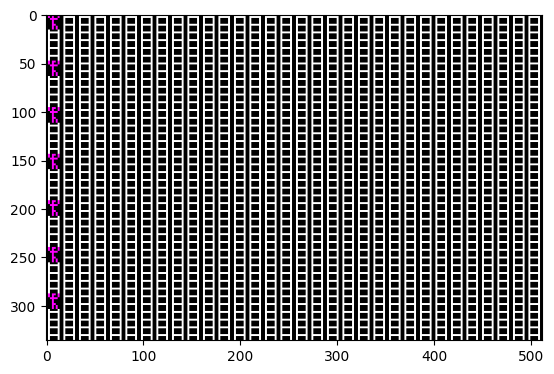

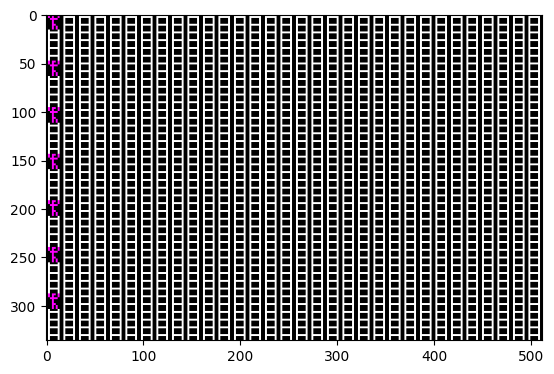

In [82]:
from Utils.Data.DataLoading import TextTileToImage

device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)
model.eval()

padSize = rowLength * 3 # lode runner row length * 3 as paper uses previous 3 rows for lstm
N = padSize

NLevels = 10

tilesIdx = [ "B", "b", "@", ".", "-", "#", "G", "E", "M" ]

np.random.seed(1000)
randStartPoint = np.random.randint(0, len(lrStringLevelPaths)-NLevels)
print(f"Random Start Point: {randStartPoint}")

for i, levelStringPath in enumerate(lrStringLevelPaths[randStartPoint:randStartPoint+NLevels]):

    input = []
    column = []
    target = []

    with open(levelStringPath, "r") as f:
        levelString = np.array([list(line[:-1]) for line in f.readlines()]).flatten()
        levelString = np.array([tiles[tileChar] for tileChar in levelString])

    for j in range(len(levelString) - N):

        padLength = (N - j) if j < N else 0
        RowCutOff = 0 if j <= N else RowCutOff+1

        dataI = np.concatenate((np.zeros(shape=(padLength)), levelString[RowCutOff:j]), axis=0)

        dataT = levelString[j:j+N]

        levelIdx = np.concatenate((np.zeros(shape=(padLength)), columnRefArray[RowCutOff:j]), axis=0)
        dataC = np.zeros(shape=(N, 256))
        for t in range(N): dataC[t][int(levelIdx[t])] = 1

        column.append(dataC)
        input.append(dataI)
        target.append(dataT)

    input = np.array(input)
    target = np.array(target)
    column = np.array(column)

    print(f"Input shape: {input.shape}")
    print(f"target shape: {target.shape}")
    print(f"column shape: {column.shape}")

    input = input.reshape(input.shape[0], input.shape[1], 1)
    target = target.reshape(target.shape[0], target.shape[1], 1)

    print(f"Input shape: {input.shape}")
    print(f"target shape: {target.shape}")
    print(f"column shape: {column.shape}")

    levelImage = np.empty(shape=((7 * 3), 32), dtype=str)

    for b in range(7):
        
        if b == 0:
            inputTensor = torch.tensor(input[b*N], dtype=torch.float32).to(device)
        else:
            inputTensor = torch.tensor(previousCol.reshape(previousCol.shape[0], 1), dtype=torch.float32).to(device)
        #input = torch.tensor(input[-1], dtype=torch.float32).to(device)
        print(f"input size: {inputTensor.size()}")
        
        targetTensor = torch.tensor(target[b*N], dtype=torch.float32).to(device)
        #target = torch.tensor(target[-1], dtype=torch.float32).to(device)
        print(f"target size: {targetTensor.size()}")
        
        columnTensor = torch.tensor(column[b*N], dtype=torch.float32).to(device)
        #column = torch.tensor(column[-1], dtype=torch.float32).to(device)
        print(f"column size: {columnTensor.size()}")

        print("Running Model")

        nextCol = model(inputTensor, targetTensor, columnTensor)
        nextCol = nextCol.cpu().detach().numpy()
        print(f"next col size: {nextCol.shape}")
        nextCol = np.argmax(nextCol, axis=1)
        print(f"next col size: {nextCol.shape}")
        #nextCol = nextCol[:, :78].reshape(6, 13, nextCol.shape[0]).transpose(1, 0, 2)

        # this reshape line is specific to bobble bubble as the level is in column wise order and only contains half the level needing to be mirrored
        # Make this compatible with lode runner
        # nextCol = nextCol.reshape(6, 13, nextCol.shape[1]).transpose(1, 0, 2)

        previousCol = nextCol
        nextCol = nextCol.reshape(3, 32)

        partLevelImage = np.zeros(shape=(nextCol.shape[0], nextCol.shape[1]), dtype=str)

        for t, row in enumerate(nextCol):
            for j, embedding in enumerate(row):
                print(embedding)
                partLevelImage[t, j] = tilesIdx[int(embedding)]
        
        print(f"Part Level Image Shape: {partLevelImage.shape}")
        levelImage[b*3:(b+1)*3, :] = partLevelImage

    # This line is bubble bobble specific to mirror the level
    # levelImage = np.concatenate([levelImage, np.fliplr(levelImage)], axis=1)

    plt.figure()
    plt.imshow(TextTileToImage(levelImage, 16, "../data/tomData/sprites/loderunner"))